### Breast cancer prediction Using Wisconsin breast cancer diagnostic data

### 라이브러리 Importing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, robust_scale, scale, normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn import metrics
import itertools
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 데이터 탐색

In [2]:
data = pd.read_csv('C:/Users/student/Desktop/data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [4]:
data.drop(["id", "Unnamed: 32"], axis=1, inplace=True)

- Prediction에 상관이 없는 'id'와 'Unnamed: 32' 컬럼 삭제

In [5]:
feature_mean = data.columns[1:11]
feature_se = data.columns[11:20]
feature_worst = data.columns[21:31]

- 평균, 표준오차, 최대/최소값이 서로 강한 상관관계를 보이기 때문에  다중공선성을 없애기 위해 평균 값만을 feature로 선택

In [6]:
data.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [7]:
data['diagnosis'] = data['diagnosis'].map({'M':1, 'B':0})

- 양성 : 1, 음성 : 0 로 mapping 

In [8]:
data.tail()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


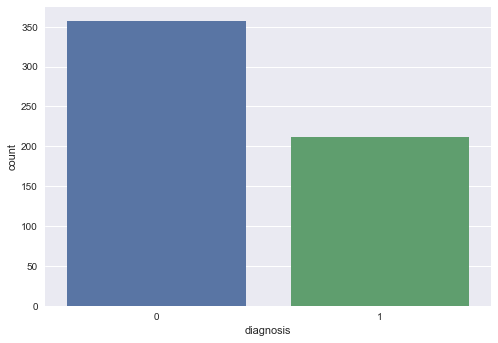

In [9]:
sns.countplot("diagnosis", data = data)
plt.show()

- Target 데이터의 갯수가 다르므로 Confusion Matrix와 ROC Curve 확인 필요

In [10]:
corr = data[feature_mean].corr()

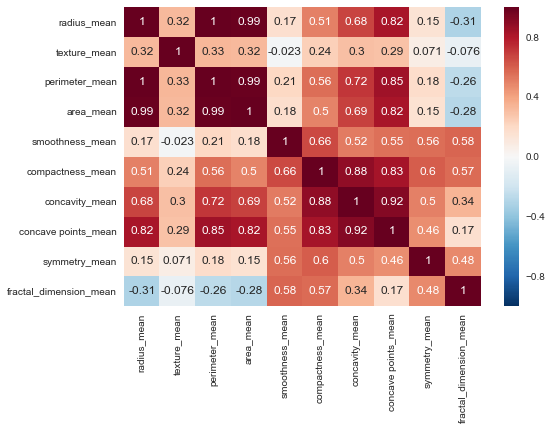

In [11]:
sns.heatmap(corr, annot=True)
plt.show()

- radius, perimeter, area 간 강한상관관계를 보임
- compactness, concavity, concave points 간 강한상관관계를 보임  

In [12]:
dataM = data[data['diagnosis'] == 1]
dataB = data[data['diagnosis'] == 0]

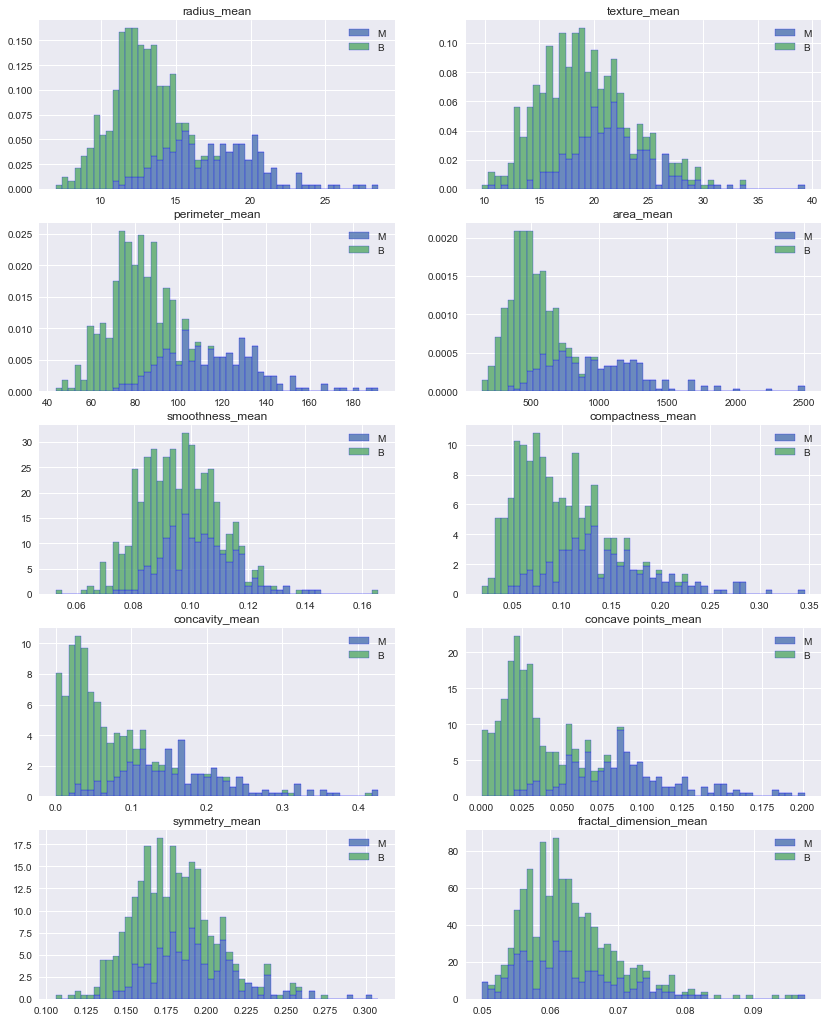

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,18))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.figure
    binwidth= (max(data[feature_mean[idx]]) - min(data[feature_mean[idx]]))/50
    ax.hist([dataM[feature_mean[idx]],dataB[feature_mean[idx]]],
            bins=np.arange(min(data[feature_mean[idx]]), 
                           max(data[feature_mean[idx]]) + binwidth, binwidth), 
            alpha=0.8,stacked=True, edgecolor='b', normed = True,label=['M', 'B'])
    ax.legend(loc='upper right')
    ax.set_title(feature_mean[idx])
           
plt.show()

- Histogram을 그려본 결과 radius, texture, perimeter, area, compactness, concavity, concave points, symmetry를 통해 Target 구분 가능
- 최종 feauture로서 texture, symmetry, PCA_feature1(radius, texture, perimeter), PCA_feature2(compactness, concavity, concave points) 선정

In [14]:
dfX = data[['texture_mean', 'symmetry_mean','radius_mean', 'area_mean', 'perimeter_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']]
dfy = data['diagnosis']

### 데이터 전처리

In [15]:
for i in dfX.columns:
    dfX[i] = StandardScaler().fit_transform(dfX[i].values.reshape(-1,1))

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


- Scikit-Learn 패키지를 활용하여 정규화 완료

In [16]:
pca_feature1 = dfX[['radius_mean', 'area_mean', 'perimeter_mean']]
pca_feature2 = dfX[['compactness_mean', 'concavity_mean', 'concave points_mean']]

- Scikit-Learn의 decomposition 서브패키지를 이용하여 강한상관관계를 보이는 feature들의 차원축소 

In [17]:
feature1 = pd.DataFrame(data = PCA(1).fit_transform(pca_feature1), columns=['pca1'])
feature2 = pd.DataFrame(data = PCA(1).fit_transform(pca_feature2), columns=['pca2'])

In [18]:
pca_feature1.head()

,radius_mean,area_mean,perimeter_mean
0,1.097064,0.984375,1.269934
1,1.829821,1.908708,1.685955
2,1.579888,1.558884,1.566503
3,-0.768909,-0.764464,-0.592687
4,1.750297,1.826229,1.776573


In [19]:
feature1.head()

,pca1
0,1.935181
1,3.131620
2,2.716609
3,-1.227375
4,3.090517


In [20]:
dfX = pd.concat([dfX[['symmetry_mean', 'texture_mean']], feature1, feature2], axis=1)

In [21]:
dfX.head()

,symmetry_mean,texture_mean,pca1,pca2
0,2.217515,-2.073335,1.935181,4.883150
1,0.001392,-0.353632,3.131620,0.025430
2,0.939685,0.456187,2.716609,2.573471
3,2.867383,0.253732,-1.227375,3.894865
4,-0.009560,-1.151816,3.090517,1.935321


- 최종 feature 준비완료

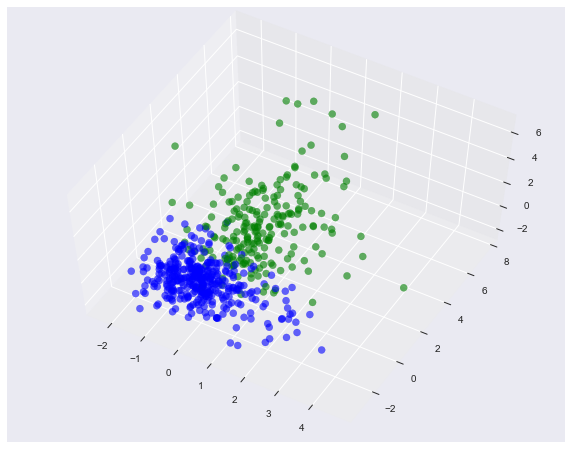

In [22]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfX['texture_mean'],dfX['pca1'],dfX['pca2'],
          c=dfy.map({0:'b', 1:'g'}), alpha=0.6, s=50)
ax.view_init(60,300)
plt.show()

- 최종 feature중 3개의 feature로 3D그래프를 통해 시각적으로 확인한결과 target의 분포가 상이함 확인

### 데이터 분리 및 모델 학습 Method 생성

In [23]:
def classification_model(model, dfX, dfy):
    model.fit(dfX, dfy)
    predictions = model.predict(dfX)
    accuracy = metrics.accuracy_score(predictions, dfy)
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))
    kf = KFold(dfX.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        X_train = dfX.iloc[train, :]
        y_train = dfy.iloc[train]
        
        model.fit(X_train, y_train)
        
        X_test = dfX.iloc[test, :]
        y_test = dfy.iloc[test]
        error.append(model.score(X_test, y_test))
        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

1. 교차검증을 위해 kFold 방법을 사용 - 총 5개의 Train Data와 Test Data Set준비
2. 준비된 Data Set을 선언된 Model에 학습 및 테스트 수행

### 의사결정나무

In [24]:
model_tree = DecisionTreeClassifier()
classification_model(model_tree, dfX, dfy)

Accuracy : 100.000%
Cross-Validation Score : 86.842%
Cross-Validation Score : 88.596%
Cross-Validation Score : 91.228%
Cross-Validation Score : 91.228%
Cross-Validation Score : 90.505%


### 로지스틱 회귀분석

In [25]:
model_LR = LogisticRegression()
classification_model(model_LR, dfX, dfy)

Accuracy : 92.970%
Cross-Validation Score : 85.088%
Cross-Validation Score : 89.035%
Cross-Validation Score : 91.228%
Cross-Validation Score : 92.105%
Cross-Validation Score : 92.622%


### 서포트벡터머신

In [26]:
model_svc = SVC(kernel="linear")
classification_model(model_svc, dfX, dfy)

Accuracy : 93.322%
Cross-Validation Score : 84.211%
Cross-Validation Score : 88.596%
Cross-Validation Score : 90.936%
Cross-Validation Score : 91.886%
Cross-Validation Score : 92.447%


### 랜덤포레스트

In [27]:
model_random_forest = RandomForestClassifier(n_estimators=100)
classification_model(model_random_forest, dfX, dfy)

Accuracy : 100.000%
Cross-Validation Score : 88.596%
Cross-Validation Score : 90.351%
Cross-Validation Score : 92.398%
Cross-Validation Score : 92.982%
Cross-Validation Score : 92.970%


### Grid Search로 하이퍼 파라미터, 모형 최적화

- 메소드 생성

In [28]:
def Model_gridsearchCV(model, param_grid, dfX, dfy):
    gs = GridSearchCV(model, param_grid, cv=10, scoring="accuracy")
    gs.fit(dfX, dfy)
    print(gs.best_params_)
    print(gs.best_estimator_)
    print(gs.best_score_)

- 커널 서포트 벡터머신 파라미터 튜닝

In [29]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
              {'C': param_range, 
               'kernel': ['linear']
              },
              {'C': param_range, 
               'gamma': param_range, 
               'kernel': ['rbf']
              },
            ]

In [30]:
Model_gridsearchCV(SVC(), param_grid, dfX, dfy)

{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9332161687170475


- 의사결정나무 파라미터 튜닝

In [31]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': [2,3,4,5,6,7,8,9,10], 
              'min_samples_leaf':[2,3,4,5,6,7,8,9,10] }

In [32]:
Model_gridsearchCV(model_tree, param_grid, dfX, dfy)

{'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 4}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.929701230228471


In [33]:
model_kscv = SVC(C=10.0, kernel="rbf", degree=3, gamma=0.1)

In [34]:
classification_model(model_kscv, dfX, dfy)

Accuracy : 94.903%
Cross-Validation Score : 86.842%
Cross-Validation Score : 88.596%
Cross-Validation Score : 90.936%
Cross-Validation Score : 91.447%
Cross-Validation Score : 91.919%


### 모형 결합 및 다수결 방법

In [35]:
model1 = LogisticRegression()
model2 = SVC(C=10.0, kernel="rbf", degree=3, gamma=0.1, probability=True)
model3 = RandomForestClassifier(n_estimators=100)

In [36]:
Voting_classifier = VotingClassifier(estimators=[('LR', model1), ('KSCV', model2), ('RF', model3)],
                                    voting='soft', weights=[1,1,1])

- Logistic Regression & Kernel SVM & Random Forest 세가지 모형을 결합하여 Soft Voting (동일 가중치)

In [37]:
classification_model(Voting_classifier, dfX, dfy)

Accuracy : 95.958%
Cross-Validation Score : 85.088%
Cross-Validation Score : 88.596%
Cross-Validation Score : 91.228%
Cross-Validation Score : 91.886%
Cross-Validation Score : 92.093%


### <font color='blue'>수행 결과 RandomForestClassifier 가장 높은 정확도 모델을 보여줌</font>

### Confusion Matrix Plot

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=0.10)

In [40]:
y_pred = model_random_forest.fit(X_train, y_train).predict(X_test)

In [41]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99        39
          1       0.95      1.00      0.97        18

avg / total       0.98      0.98      0.98        57



Confusion matrix, without normalization
[[38  1]
 [ 0 18]]


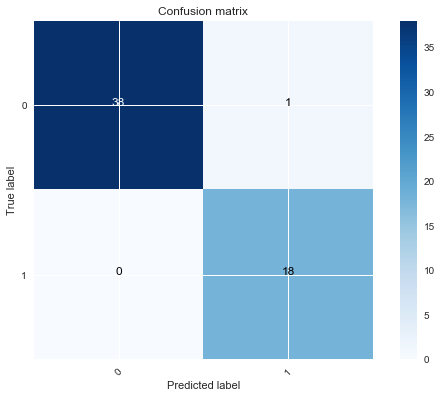

In [42]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0', '1'])
plt.show()

In [43]:
model_random_forest.feature_importances_

array([ 0.05752779,  0.13673947,  0.49028599,  0.31544675])

In [45]:
X_train.columns

Index(['symmetry_mean', 'texture_mean', 'pca1', 'pca2'], dtype='object')

### 결론 및 마무리

1. 가장 뛰어난 성능의 모델은 Random Forest / 교차검증 결과(kFold=5) 88.58 ~92.97%
2. 90%의 데이터를 사용하여 학습한 경우 Accuracy 98% -> 데이터가 충분하다면 견고한 모델 완성이 가능 
3. 중요한 feature는 PCA1(radius, area, perimeter) - PCA2(compactness, concavity, concave points) - texture - symmetry 순
4. 내부 데이터에 더하여 활용 가능한 외부데이터가 있는지 추가적인 연구 필요